# Example notebook

In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

## Parsed labels

## Networks prediction for the segmentation

In [4]:
from floortrans.plotting import walls_to_image, walls_and_rooms_to_image
import time
import cv2
image_path = r"G:\test_dataset\images\architectural-floor-plans-ground-floor-set-forward-both-sides.png"
n_rooms = 12
n_icons = 11
with torch.no_grad():
    fplan = cv2.imread(image_path)
    fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)    
    width = 1024
    height = 1024
    img_size = (height, width)
    dim = (width, height)
    fplan = cv2.resize(fplan, dim, interpolation=cv2.INTER_LANCZOS4)
    # plt.figure(figsize=(12, 12))
    # ax2 = plt.subplot(1, 1, 1)
    # ax2.axis('off')
    # ax2.imshow(fplan, vmin=0, vmax=n_rooms-0.1)
    # plt.tight_layout()
    # plt.savefig('input_image.png')  # Save as PNG file
    while True:
        start = time.time()
        img = np.moveaxis(fplan, -1, 0)
        img = 2 * (img / 255.0) - 1
        img = torch.tensor(img.astype(np.float32)).unsqueeze(0).cuda()
        prediction = model(img)
        print(1 / (time.time() - start))
        prediction = F.interpolate(prediction, size=(height, width), mode='bilinear', align_corners=True).detach().cpu()
        heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
        polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])
rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
# predicted_classes = np.argmax(rooms_pred, axis=0) 
# target_class = 11
# positions = np.where(predicted_classes == target_class)
# columns_of_interest = rooms_pred[:, positions[0], positions[1]]
# max_values = columns_of_interest.max(axis=0)
# second_max_values = np.partition(columns_of_interest, -2, axis=0)[-2, :]
# mask = (columns_of_interest == max_values)
# columns_of_interest[mask] = second_max_values.repeat(mask.sum(axis=0))
# rooms_pred[:, positions[0], positions[1]] = columns_of_interest
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)


8.816897618727298
(12, 1024, 1024)
12.625763842481382
(12, 1024, 1024)
15.054337409506445
(12, 1024, 1024)
8.251387427087534
(12, 1024, 1024)
8.5062839319141
(12, 1024, 1024)
4.637105877332343
(12, 1024, 1024)
10.002346589337327
(12, 1024, 1024)
11.961784384072644
(12, 1024, 1024)
9.567059220685612
(12, 1024, 1024)
9.185767253821103
(12, 1024, 1024)


KeyboardInterrupt: 

## Post-processed polygons

(12, 530, 919)
[[508 332]
 [512 332]
 [512 380]
 [508 380]]
[[600  83]
 [645  83]
 [645  91]
 [600  91]]
[[541 102]
 [582 102]
 [582 110]
 [541 110]]
[[377 244]
 [419 244]
 [419 248]
 [377 248]]
[[377 103]
 [410 103]
 [410 109]
 [377 109]]
[[664 103]
 [697 103]
 [697 109]
 [664 109]]
[[512 103]
 [551 103]
 [551 109]
 [512 109]]
[[508 245]
 [551 245]
 [551 249]
 [508 249]]
[[140 403]
 [148 403]
 [148 483]
 [140 483]]
[[ 32 473]
 [148 473]
 [148 483]
 [ 32 483]]
[[246 328]
 [252 328]
 [252 409]
 [246 409]]
[[140 403]
 [252 403]
 [252 409]
 [140 409]]
[[896 223]
 [910 223]
 [910 302]
 [896 302]]
[[796 290]
 [910 290]
 [910 302]
 [796 302]]
[[542 330]
 [550 330]
 [550 424]
 [542 424]]
[[487 416]
 [550 416]
 [550 424]
 [487 424]]
[[487 376]
 [512 376]
 [512 380]
 [487 380]]
[[796 302]
 [802 302]
 [802 409]
 [796 409]]
[[691 397]
 [802 397]
 [802 409]
 [691 409]]
[[ 79 226]
 [ 81 226]
 [ 81 285]
 [ 79 285]]
[[ 32 283]
 [ 81 283]
 [ 81 285]
 [ 32 285]]
[[ 32 331]
 [ 40 331]
 [ 40 473]
 [ 32 4

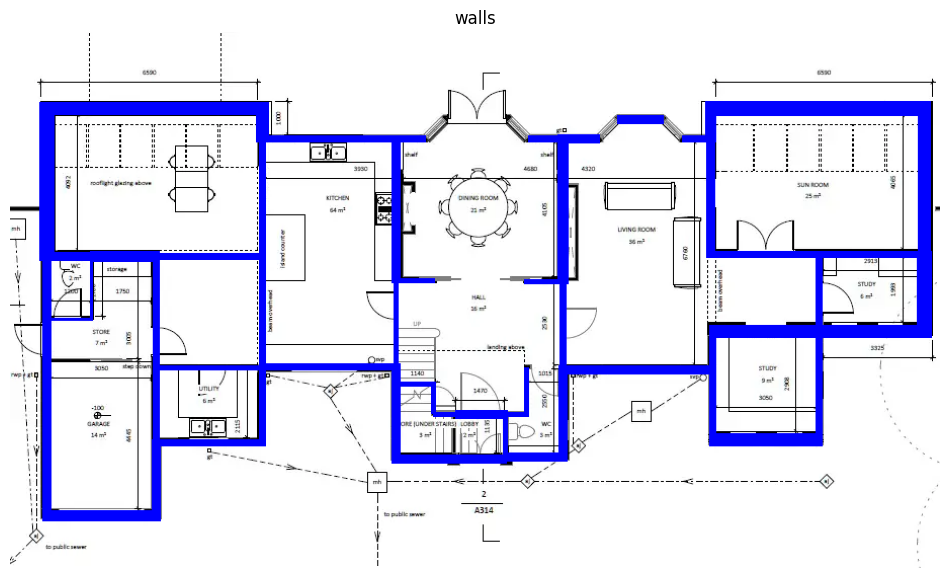

In [18]:
from floortrans.plotting import walls_to_image, walls_and_rooms_to_image
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])
from shapely.geometry import Polygon
shape_polygons = [Polygon(array) for array in polygons]
for j, icon in enumerate(shape_polygons):
    if types[j]['type'] == 'wall':
        print(polygons[j])
image =  walls_to_image(polygons, types, image_path)
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.title('walls')
plt.axis('off')
plt.savefig("wall_overlap_iamge.png")
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
# plt.figure(figsize=(12,12))
# ax = plt.subplot(1, 1, 1)
# ax.axis('off')
# rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
# cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
# cbar.ax.set_yticklabels(room_classes, fontsize=20)
# plt.tight_layout()
# plt.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
# plt.savefig("rooms.png")
# plt.figure(figsize=(12,12))
# ax = plt.subplot(1, 1, 1)
# ax.axis('off')
# iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
# cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
# cbar.ax.set_yticklabels(icon_classes, fontsize=20)
# plt.tight_layout()
# plt.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
# plt.savefig("furniture.png")

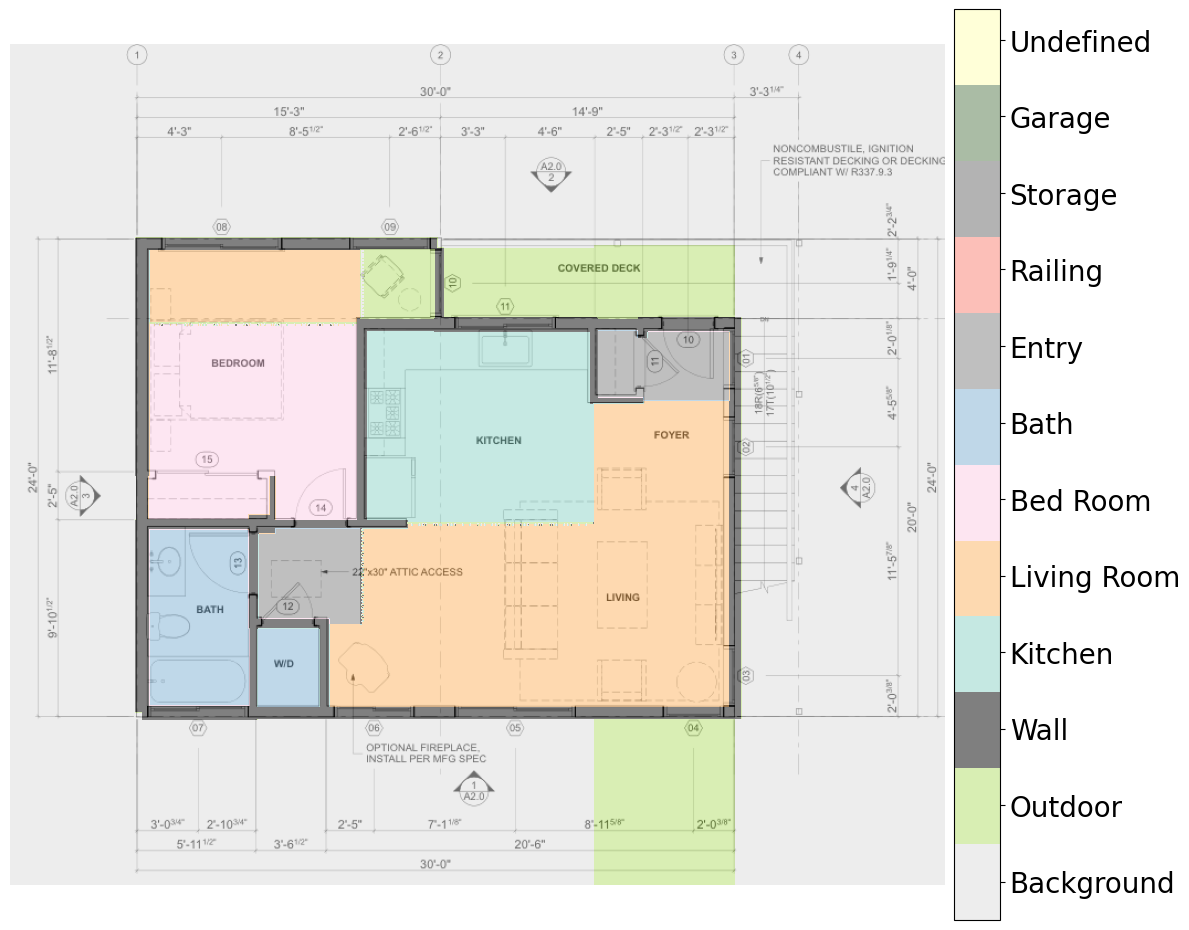

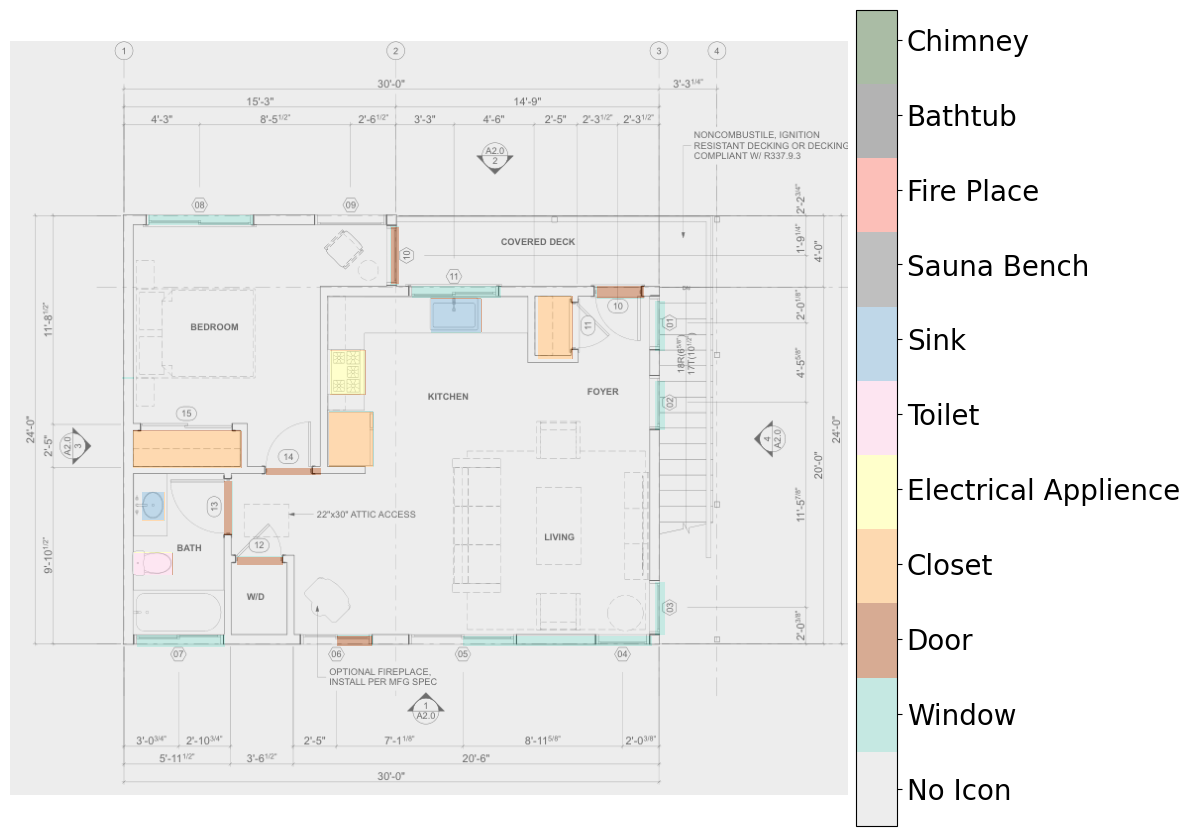

In [4]:
fig_combined, ax_combined = plt.subplots(figsize=(12, 12))
ax_combined.imshow(fplan, cmap='gray')  # Plot the uncolored image first
rseg = ax_combined.imshow(pol_room_seg, cmap='rooms', alpha=0.5, vmin=0, vmax=n_rooms-0.1)  # Overlay with segmented image
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("blended_image_rooms.png")


fig_combined, ax_combined = plt.subplots(figsize=(12, 12))
ax_combined.imshow(fplan, cmap='gray')  # Plot the uncolored image first
iseg = ax_combined.imshow(pol_icon_seg, cmap='icons', alpha=0.5, vmin=0, vmax=n_icons-0.1)  # Overlay with segmented image
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("blended_image_furnitures.png")